In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [16]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [3]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

In [4]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label


In [5]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 50000
Test size: 10000


In [6]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

In [9]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    
    
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       46592     
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 14, 14, 128)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 256)       

In [10]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']    
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [11]:
history=model.fit(
    train_ds,
    epochs=1,
    validation_data=test_ds,
    validation_freq=1
)

1562/1562 [==============================] - 629s 398ms/step - loss: 2.0674 - accuracy: 0.2537 - val_loss: 1.6161 - val_accuracy: 0.4343


In [ ]:
# base model accuracy
# batch_size = 64
# epochs = 1
# model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

In [12]:
# Test baseline accuracy
import tempfile

_, baseline_model_accuracy = model.evaluate(test_ds, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)


Baseline test accuracy: 0.4344951808452606


In [13]:
# base model saved location
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

Saving model to:  /tmp/tmpu1w64t9_.h5


In [ ]:
###############################
########### PRUNING ###########
###############################

In [14]:
pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
## Prunning the entire dataset

import tensorflow_model_optimization as tfmot
import numpy as np

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# batch_size & epochs stay the same as the baseline model
batch_size = 64
epochs = 1


# Define model for pruning.
# For the pruning schedule, we start at the sparsity level 50% 
# and gradually train the model to reach 90% sparsity. 
# 90% of the weight tensor is going to be pruned away.

x = 0.2
sparsity = []
acc = []
while x <= 0.9:
  print("current x is: ",x)
  sparsity.append(x)
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(x, begin_step=0, frequency=100)
  }
  callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep()
    ]

  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

  history_pruned = model_for_pruning.fit(train_ds,
                      batch_size=batch_size, epochs=epochs, validation_data=test_ds,
                      callbacks=callbacks)
    
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(test_ds, verbose=0)

  print("current x is: ",x, "and model acc is: ",model_for_pruning_accuracy)
  acc.append(model_for_pruning_accuracy)
  print("sparsity: ", sparsity)
  print("accuracy list: ", acc)
  x += 0.1

# model_for_pruning.summary()

current x is:  0.2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1562/1562 [==============================] - 646s 406ms/step - loss: 1.5754 - accuracy: 0.4294 - val_loss: 1.4803 - val_accuracy: 0.4769
current x is:  0.2 and model acc is:  0.47706329822540283
sparsity:  [0.2]
accuracy list:  [0.47706329822540283]
current x is:  0.30000000000000004
1562/1562 [==============================] - 648s 408ms/step - loss: 1.2065 - accuracy: 0.5838 - val_loss: 1.0416 - val_accuracy: 0.6379
current x is:  0.30000000000000004 and model acc is:  0.6375200152397156
sparsity:  [0.2, 0.30000000000000004]
accuracy list:  [0.47706329822540283, 0.6375200152397156]
current x is:  0.4
1562/1562 [==============================] - 676s 425ms/step - loss: 0.9976 - accuracy: 0.6614 - val_loss: 1.1092 - val_accuracy: 0.6146
current x is:  0.4 and model acc is:  0.6145833134651184
sparsity:  [0.2, 0.30000000000000004, 0.4]
accuracy list:  [0.47706329822540283, 0.6375200152397156, 0.6145833134651184]
current x is:  0.5
1562/1562 [==============================] - 629s 396ms/

In [17]:
sparsity = [round(x, 2) for x in sparsity]
sparsity

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [18]:
acc

[0.47706329822540283,
 0.6375200152397156,
 0.6145833134651184,
 0.6988180875778198,
 0.7258613705635071,
 0.7368789911270142,
 0.745192289352417,
 0.7452924847602844]

In [19]:
# # fit the pruned model

# logdir = tempfile.mkdtemp()

# callbacks = [
#   tfmot.sparsity.keras.UpdatePruningStep(),
#   tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
# ]

# history_pruned = model_for_pruning.fit(x_train,y_train,
#                   batch_size=batch_size, epochs=epochs, validation_split=validation_split,
#                   callbacks=callbacks)

In [20]:
# Test out pruned model accuracy
# _, model_for_pruning_accuracy = model_for_pruning.evaluate(
#    x_train,y_train, verbose=0)

In [21]:
# compare results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.4344951808452606
Pruned test accuracy: 0.7452924847602844


In [22]:
# Once our pre-trained model achieved desirable accuracy
# we save the model trained model and make it “prunable”
# _, keras_file = tempfile.mkstemp('.h5')
# tf.keras.models.save_model(model_for_pruning, keras_file, include_optimizer=False)
# print('Saved baseline model to:', keras_file)

In [23]:
compression_ratio = [1/x for x in sparsity]
compression_ratio

[5.0,
 3.3333333333333335,
 2.5,
 2.0,
 1.6666666666666667,
 1.4285714285714286,
 1.25,
 1.1111111111111112]

In [24]:
acc

[0.47706329822540283,
 0.6375200152397156,
 0.6145833134651184,
 0.6988180875778198,
 0.7258613705635071,
 0.7368789911270142,
 0.745192289352417,
 0.7452924847602844]

In [25]:
# pruned model saved
_, pruned_keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', pruned_keras_file)
tf.keras.models.save_model(model_for_pruning, pruned_keras_file, include_optimizer=False)

Saving model to:  /tmp/tmppx9g7aru.h5


In [26]:
###############################
###### PRUNING RESULT #########
###############################

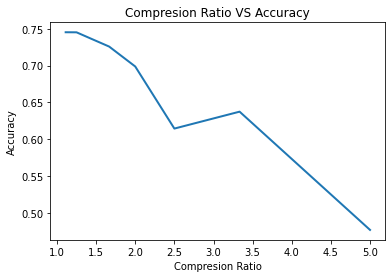

In [27]:
# compression ratio vs accuracy graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.scatter(compression_rat, acc)
ax.plot(compression_ratio, acc, linewidth=2.0)
plt.xlabel('Compresion Ratio')
plt.ylabel('Accuracy')
plt.title('Compresion Ratio VS Accuracy')
plt.show()

In [28]:
# accuracy results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy (90% pruned rate):', model_for_pruning_accuracy)

Baseline test accuracy: 0.4344951808452606
Pruned test accuracy (90% pruned rate): 0.7452924847602844


In [29]:
# pruned model summary
# model_for_pruning.summary()

In [30]:
# base model summary
# model.summary()

In [31]:
# helper function to get model size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [32]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))

Size of gzipped baseline Keras model: 10746207.00 bytes
Size of gzipped pruned Keras model: 2653329.00 bytes


In [33]:
# confusion matrix for based model
# from sklearn.metrics import confusion_matrix
# import numpy as np
# test_predictions = model.predict(x_test)
# confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
# confusion

In [34]:
# confusion matrix for pruned model
# p_test_predictions = model_for_pruning.predict(x_test)
# p_confusion = confusion_matrix(y_test, np.argmax(p_test_predictions,axis=1))
# p_confusion

In [35]:
###############################
######## Quantization #########
###############################

In [37]:
## Quantization 
import tensorflow_model_optimization as tfmot

model_quant = tfmot.quantization.keras.quantize_model(model)
model_quant.compile(optimizer='adam', loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model_quant.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (QuantizeL  (None, 64, 64, 3)        3         
 ayer)                                                           
                                                                 
 quant_conv2d_5 (QuantizeWra  (None, 14, 14, 128)      46849     
 pperV2)                                                         
                                                                 
 quant_batch_normalization_5  (None, 14, 14, 128)      513       
  (QuantizeWrapperV2)                                            
                                                                 
 quant_activation_5 (Quantiz  (None, 14, 14, 128)      3         
 eWrapperV2)                                                     
                                                                 
 quant_max_pooling2d_3 (Quan  (None, 7, 7, 128)       

In [38]:
model_quant.fit(train_ds, batch_size=64, epochs=1, validation_data=test_ds)

1562/1562 [==============================] - 771s 485ms/step - loss: 0.9192 - accuracy: 0.7000 - val_loss: 0.9634 - val_accuracy: 0.6793


In [39]:
# quant model saved
converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
quant_tflite_model = converter.convert()

_, quant_tflite_file = tempfile.mkstemp('.h5')

with open(quant_tflite_file, 'wb') as f:
  f.write(quant_tflite_model)

print('Saved pruned TFLite model to:', quant_tflite_file)


Saved pruned TFLite model to: /tmp/tmpr1abvplv.h5


In [ ]:
#####################################
######## Quantization Result#########
#####################################

In [41]:
# Accuracy comparisons
_, model_quant_accuracy = model_quant.evaluate(test_ds, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Quantization test accuracy:', model_quant_accuracy)

Baseline test accuracy: 0.4344951808452606
Quantization test accuracy: 0.6790865659713745


In [42]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped quantization Keras model: %.2f bytes" % (get_gzipped_model_size(quant_tflite_file)))

Size of gzipped baseline Keras model: 10746207.00 bytes
Size of gzipped quantization Keras model: 7661527.00 bytes


In [ ]:
#########################################
######## Pruning + Quantization #########
#########################################

In [43]:
## Prunning the entire dataset

import tensorflow_model_optimization as tfmot
import numpy as np

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# batch_size & epochs stay the same as the baseline model
batch_size = 64
epochs = 1


# Define model for pruning.
# For the pruning schedule, we start at the sparsity level 50% 
# and gradually train the model to reach 90% sparsity. 
# 90% of the weight tensor is going to be pruned away.

x = 0.2
sparsity_pq = []
acc_pq = []
while x <= 0.9:
  print("current x is: ",x)
  sparsity_pq.append(x)
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(x, begin_step=0, frequency=100)
  }
  callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep()
    ]

  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

  history_pruned = model_for_pruning.fit(train_ds,
                      batch_size=batch_size, epochs=epochs, validation_data=test_ds,
                      callbacks=callbacks)

                      
  model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
  model_quant_prune = tfmot.quantization.keras.quantize_model(model_for_export)
  model_quant_prune.compile(optimizer='adam', loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
  model_quant_prune.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=test_ds)
    
  _, model_quant_prune_accuracy = model_quant_prune.evaluate(test_ds, verbose=0)

  print("current x is: ",x, "and model acc is: ",model_quant_prune_accuracy)
  acc_pq.append(model_quant_prune_accuracy)
  print("sparsity: ", sparsity_pq)
  print("accuracy list: ", acc_pq)
  x += 0.1

# model_for_pruning.summary()

current x is:  0.2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1562/1562 [==============================] - 743s 471ms/step - loss: 0.8141 - accuracy: 0.7356 - val_loss: 0.9574 - val_accuracy: 0.6947
current x is:  0.2 and model acc is:  0.6948117017745972
sparsity:  [0.2]
accuracy list:  [0.6948117017745972]
current x is:  0.30000000000000004
1562/1562 [==============================] - 783s 498ms/step - loss: 0.7301 - accuracy: 0.7631 - val_loss: 0.9430 - val_accuracy: 0.7011
current x is:  0.30000000000000004 and model acc is:  0.7014222741127014
sparsity:  [0.2, 0.30000000000000004]
accuracy list:  [0.6948117017745972, 0.7014222741127014]
current x is:  0.4
1562/1562 [==============================] - 758s 481ms/step - loss: 0.6550 - accuracy: 0.7918 - val_loss: 1.0375 - val_accuracy: 0.6856
current x is:  0.4 and model acc is:  0.6855969429016113
sparsity:  [0.2, 0.30000000000000004, 0.4]
accuracy list:  [0.6948117017745972, 0.7014222741127014, 0.6855969429016113]
current x is:  0.5
1562/1562 [==============================] - 755s 480ms/step

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')
with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

In [45]:
#########################################
##### Pruning + Quantization Result #####
#########################################

In [46]:
compression_pq_ratio = [1/x for x in sparsity_pq]
compression_pq_ratio

[5.0,
 3.333333333333333,
 2.5,
 2.0,
 1.6666666666666667,
 1.4285714285714286,
 1.25,
 1.1111111111111112]

In [47]:
acc_pq

[0.6948117017745972,
 0.7014222741127014,
 0.6855969429016113,
 0.7003205418586731,
 0.7012219429016113,
 0.6994190812110901,
 0.6957131624221802,
 0.7026242017745972]

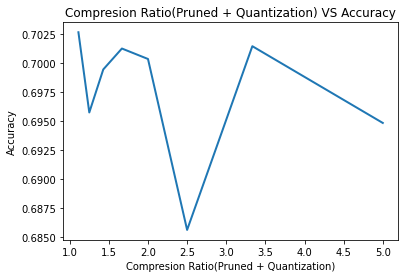

In [48]:
# compression ratio vs accuracy graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.scatter(compression_rat, acc)
ax.plot(compression_pq_ratio, acc_pq, linewidth=2.0)
plt.xlabel('Compresion Ratio(Pruned + Quantization)')
plt.ylabel('Accuracy')
plt.title('Compresion Ratio(Pruned + Quantization) VS Accuracy')
plt.show()

In [49]:
# accuracy results
print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned + Quantization test accuracy:', model_quant_prune_accuracy)

Baseline test accuracy: 0.4344951808452606
Pruned + Quantization test accuracy: 0.7026242017745972


In [50]:
# compare model size
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

Size of gzipped baseline Keras model: 10746207.00 bytes
Size of gzipped pruned and quantized TFlite model: 613250.00 bytes


In [ ]:
# confusion matrix for based model
# from sklearn.metrics import confusion_matrix
# import numpy as np
# test_predictions = model.predict(x_test)
# confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
# confusion

In [ ]:
# confusion matrix for pruned+quantized model
# pq_test_predictions = model_quant_prune.predict(x_test)
# pq_confusion = confusion_matrix(y_test, np.argmax(pq_test_predictions,axis=1))
# pq_confusion